In [1]:
%matplotlib inline
from __future__ import division

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from itertools import product
from biom import load_table

from scipy.stats import mannwhitneyu

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('poster')

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

In [2]:
# Mathematica's default color list
colors = [(0.368417,0.506779,0.709798),
          (0.880722,0.611041,0.142051),
          (0.560181,0.691569,0.194885),
          (0.922526,0.385626,0.209179),
          (0.528488,0.470624,0.701351),
          (0.772079,0.431554,0.102387),
          (0.363898,0.618501,0.782349),
          (1,0.75,0),
          (0.647624,0.37816,0.614037),
          (0.571589,0.586483,0.),
          (0.915,0.3325,0.2125),
          (0.400822,0.522007,0.85),
          (0.972829,0.621644,0.073362),
          (0.736783,0.358,0.503027),
          (0.280264,0.715,0.429209)]
sns.set_palette(colors)

In [3]:
from __future__ import division
from scipy.stats import skew, kurtosis
import numpy as np

def sarles_bimodality_coefficient(a):
    """Calculate Sarle's biomodality coefficient b
    
    Parameters
    ----------
    a : array-like
        One dimensional distribution.
        
    Returns
    -------
    float
        Sarle's b (ranging from zero to one), if the value is
        greater than 5/9 then we say the distribution
        approximates bimodality. This value ranges from 0 to 1.
        
    References
    ----------
    .. [1] Roland Pfister, Katharina A. Schwarz, Markus Janczyk,
       Rick Dale and Jonathan B. Freeman. "Good things peak in
       pairs: a note on the bimodality coefficient". Front. Psychol.,
       02 October 2013. http://dx.doi.org/10.3389/fpsyg.2013.00700
    """
    a = np.asarray(a)
    
    g = skew(a, bias=False)
    k = kurtosis(a, bias=False)
    n = len(a)
    
    numerator = (g**2) + 1
    denominator_left = k
    denominator_right = 3 * ( ((n-1)**2) / ((n-2)*(n-3)) )
    
    b = numerator / (denominator_left + denominator_right)
    
    return b

# these test cases were adapted from Knapp 2007 (see figure 7)
# and from Pfister 2015 (see supplementary materials Table 1)
A = np.array([1]*3 + [2]*5 + [3]*5 + [4]*10 + [5]*17 +
             [6]*20 + [7]*17 + [8]*10 + [9]*5 + [10]*5 + [11]*3)
B = np.array([1]*2 + [2]*26 + [3]*14 + [4]*6 + [5]*2 + [7]*2 +
             [8]*6 + [9]*14 + [10]*26 + [11]*2)
C = np.array([1]*2 + [2]*3 + [3]*3 + [4]*3 + [5]*4 +
             [6]*4 + [7]*5 + [8]*11 + [9]*21 + [10]*41 + [11]*4)
D = np.array([1]*2 + [2]*3 + [3]*6 + [4]*17 + [5]*3 +
             [6]*4 + [7]*5 + [8]*12 + [9]*14 + [10]*30 + [11]*4)

np.testing.assert_almost_equal(sarles_bimodality_coefficient(A), 0.34, 2)
np.testing.assert_almost_equal(sarles_bimodality_coefficient(B), 0.79, 2)
np.testing.assert_almost_equal(sarles_bimodality_coefficient(C), 0.73, 2)
np.testing.assert_almost_equal(sarles_bimodality_coefficient(D), 0.67, 2)

In [7]:
mf = load_mf('metadata-2/mapping_file.fixed.alpha.cleaned.txt')
bt = load_table('analysis/beta/otu_table.ids.nocontaminants.noblanks_even7400.biom')

mf = mf.loc[bt.ids()]

for metric in ['PD_whole_tree_even_7400_alpha', 'observed_species_even_7400_alpha',
               'shannon_even_7400_alpha', 'chao1_even_7400_alpha']:
    mf[metric] = mf[metric].convert_objects(convert_numeric=True)
    
mf.dropna(inplace=True)

mf.SURGERY.replace({'ileocecal resection': 'Yes', 'colonresection, ileorectal anastomosis': 'Yes',
                    'small bowelbowel resections(2x)': 'Yes', 'Ileocolectomy': 'Yes',
                    'Ilececal and ileal resection': 'Yes', 'Ilecectomy': 'Yes'}, inplace=True)

def funk(line):
    if line['IBD'] == 'Crohns' and line['SURGERY'] == 'No':
        return 'CD'
    elif line['IBD'] == 'Crohns' and line['SURGERY'] == 'Yes':
        return 'CD (surgery)'
    # hans confirmed this was the case
    elif line['IBD'] == 'Crohns' and line['SURGERY'] == 'NA':
        return 'CD'
    elif line['IBD'] == 'Healthy Controls' and line['SURGERY'] == 'NA':
        return 'Controls'
    else:
        raise ValueError('Something bad happened')

mf['SURGERY_AND_IBD'] = mf.apply(funk, axis=1, reduce=False)

# Visualize the distributions of alpha diversity (by health status)

PD_whole_tree_even_7400_alpha
Healthy Controls b=0.31052 | dip's p-value=0.99276
Crohns b=0.41526 | dip's p-value=0.04382
shannon_even_7400_alpha
Healthy Controls b=0.43976 | dip's p-value=0.25854
Crohns b=0.49620 | dip's p-value=0.90843
chao1_even_7400_alpha
Healthy Controls b=0.32627 | dip's p-value=0.93189
Crohns b=0.45367 | dip's p-value=0.18126


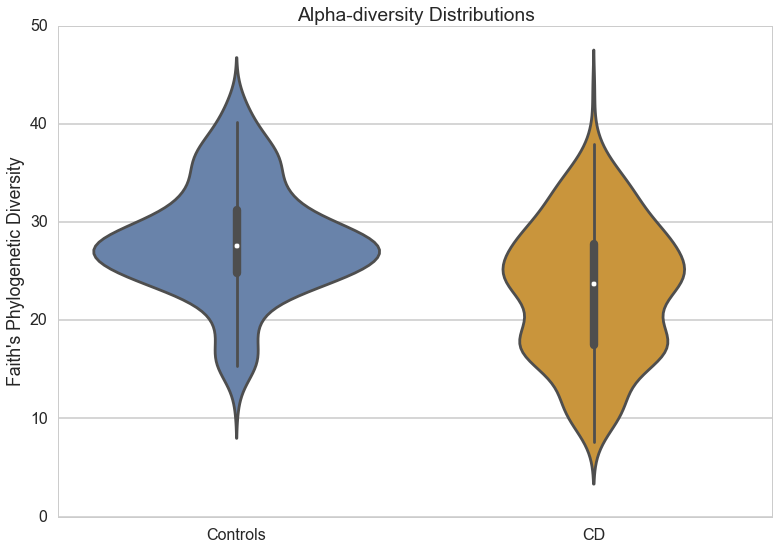

In [14]:
from os.path import join
from diptest.diptest import diptest

!mkdir -p analysis/alpha/distributions-by-surgery-and-ibd

path = 'analysis/alpha/distributions-by-surgery-and-ibd'

metrics = ['PD_whole_tree_even_7400_alpha',
           'shannon_even_7400_alpha',
           'chao1_even_7400_alpha']

suribd = mf.IBD.unique()
for metric in metrics:
    bs = [sarles_bimodality_coefficient(mf[mf.IBD == a][metric]) for a in suribd]
    ds = [diptest(mf[mf.IBD == a][metric].values)[1] for a in suribd]
    print metric
    print '\n'.join(["%s b=%.5f | dip's p-value=%.5f" % (a, b, d) for a, b, d in zip(suribd, bs, ds)])

rep = {'IBD': {'Healthy Controls': 'Controls', 'Crohns': 'CD'}}
sns.violinplot(x='IBD', y='PD_whole_tree_even_7400_alpha', data=mf.replace(rep), size=1)
plt.xlabel('')
plt.ylabel("Faith's Phylogenetic Diversity")
plt.title('Alpha-diversity Distributions')
plt.savefig('analysis/alpha/distributions-by-ibd/figure1.pdf')

# Visualize the distributions of alpha diversity by health and surgery status

PD_whole_tree_even_7400_alpha
Controls b=0.31052 | dip's p-value=0.99276
CD b=0.42114 | dip's p-value=0.22951
CD (surgery) b=0.46651 | dip's p-value=0.18365
chao1_even_7400_alpha
Controls b=0.32627 | dip's p-value=0.93189
CD b=0.46579 | dip's p-value=0.00043
CD (surgery) b=0.43743 | dip's p-value=0.82236
shannon_even_7400_alpha
Controls b=0.43976 | dip's p-value=0.25854
CD b=0.48376 | dip's p-value=0.44887
CD (surgery) b=0.49312 | dip's p-value=0.29389


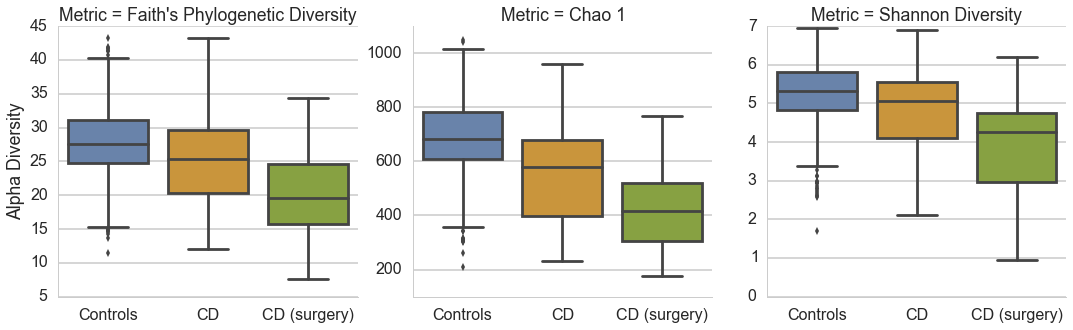

In [15]:
from os.path import join
from diptest.diptest import diptest

!mkdir -p analysis/alpha/distributions-by-surgery-and-ibd

path = 'analysis/alpha/distributions-by-surgery-and-ibd'
metrics = ['PD_whole_tree_even_7400_alpha', 'chao1_even_7400_alpha', 'shannon_even_7400_alpha']

suribd = mf.SURGERY_AND_IBD.unique()
for metric in metrics:
    bs = [sarles_bimodality_coefficient(mf[mf.SURGERY_AND_IBD == a][metric]) for a in suribd]
    ds = [diptest(mf[mf.SURGERY_AND_IBD == a][metric].values)[1] for a in suribd]
    print metric
    print '\n'.join(["%s b=%.5f | dip's p-value=%.5f" % (a, b, d) for a, b, d in zip(suribd, bs, ds)])
    
melt_mf = pd.melt(mf, id_vars=['IBD', 'SURGERY_AND_IBD'], var_name='Metric',
                  value_vars=metrics, value_name='Alpha Diversity')
melt_mf.Metric.replace({'PD_whole_tree_even_7400_alpha': "Faith's Phylogenetic Diversity",
                        "shannon_even_7400_alpha": "Shannon Diversity",
                        "chao1_even_7400_alpha": "Chao 1"}, inplace=True)
g = sns.factorplot(x='SURGERY_AND_IBD', y='Alpha Diversity', data=melt_mf,
                   col='Metric', sharey=False, kind='box', size=5)
g.set_xlabels('')
g.savefig('analysis/alpha/distributions-by-surgery-and-ibd/figure2.pdf')

In [53]:
for cat in mf.SURGERY_AND_IBD.unique():
    print cat, len(mf[mf.SURGERY_AND_IBD == cat].HOST_SUBJECT_ID.value_counts())

Controls 12
Crohns 10
Crohns (surgery) 8


# Statistical comparison between the health statuses

Comparison of healthy subjectse between the other disease statuses.

In [18]:
metrics = ['PD_whole_tree_even_7400_alpha', 'shannon_even_7400_alpha', 'chao1_even_7400_alpha']

In [19]:
for metric in metrics:
    a = mf[mf['SURGERY_AND_IBD'] == 'Controls'][metric].values
    print 'Metric: %s' % metric
    
    for stat in ['Crohns', 'Crohns (surgery)']:
        b = mf[mf['SURGERY_AND_IBD'] == stat][metric].values
        u, p = mannwhitneyu(a, b)

        print 'Comparing Controls vs %s: p = %f, u = %0.3f' % (stat, p, u)

Metric: PD_whole_tree_even_7400_alpha
Comparing Controls vs Crohns: p = 0.000001, u = 30158.000
Comparing Controls vs Crohns (surgery): p = 0.000000, u = 9811.000
Metric: shannon_even_7400_alpha
Comparing Controls vs Crohns: p = 0.000009, u = 31018.000
Comparing Controls vs Crohns (surgery): p = 0.000000, u = 9930.000
Metric: chao1_even_7400_alpha
Comparing Controls vs Crohns: p = 0.000000, u = 23400.000
Comparing Controls vs Crohns (surgery): p = 0.000000, u = 5594.000


Comparing subjects with CD and CD (surgery). All the differences are significant.

In [20]:
for metric in metrics:
    a = mf[mf['SURGERY_AND_IBD'] == 'Crohns'][metric].values
    b = mf[mf['SURGERY_AND_IBD'] == 'Crohns (surgery)'][metric].values
    print 'Metric: %s' % metric
    
    u, p = mannwhitneyu(a, b)

    print 'Comparing Crohns vs Crohns (surgery): p = %f, u = %0.3f' % (p, u)

Metric: PD_whole_tree_even_7400_alpha
Comparing Crohns vs Crohns (surgery): p = 0.000000, u = 8746.000
Metric: shannon_even_7400_alpha
Comparing Crohns vs Crohns (surgery): p = 0.000000, u = 8678.000
Metric: chao1_even_7400_alpha
Comparing Crohns vs Crohns (surgery): p = 0.000000, u = 8014.000
